# Regression Model

We implemented a linear regression model to predict `Mean_Relative_MCL` and `...` from socioeconomic features (e.g. `Median_Income`, `Poverty_Rate`). 

Question of interest: 
Can we use socioeconomic variables (income and poverty rate) to predict the degree of water contamination in U.S. counties, using linear regression as a predictive model?

## Preprocessing the data


In [22]:
"""Load libraries"""

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

colors = [
    sns.color_palette("viridis", as_cmap=True)(0.2),
    sns.color_palette("viridis", as_cmap=True)(0.4),
    sns.color_palette("viridis", as_cmap=True)(0.7),
    sns.color_palette("viridis", as_cmap=True)(0.9)
]

In [23]:
"""Load data"""

# List of file names
files = [f"df{i}.csv" for i in range(1, 13)]
dfs = [pd.read_csv(file, sep=",", encoding="latin1") for file in files]

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

(1499860, 22)


In [24]:
"""Data preprocessing: Create separate data frames for 2023, Aggregation per COUNTY"""

df["CollectionDate"] = pd.to_datetime(df["CollectionDate"], errors='coerce')

df.loc[:, "Total_Samples"] = df["MRL_Exceeded"] + df["MRL_Not_Exceeded"]

# Create separate file for 2023 data only
df_2023 = df[df["CollectionDate"].dt.year == 2023].copy()

# Aggregate data per county
df_counties = df_2023.groupby("County").agg(
    State=('State', lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]), 
    Total_Samples=('Total_Samples', 'sum'),
    MRL_Not_Exceeded=('MRL_Not_Exceeded', 'sum'),
    MRL_Exceeded=('MRL_Exceeded', 'sum'),
    MCL_Not_Exceeded=('MCL_Not_Exceeded', 'sum'),
    MCL_Exceeded=('MCL_Exceeded', 'sum'),
    Max_Relative_MRL=('Relative_MRL', 'max'),
    Max_Relative_MCL=('Relative_MCL', 'max'),
    Median_Income=('Median_Income', 'max'),
    Poverty_Rate=('Poverty_Rate', 'max')
).reset_index()

# Compute Mean_Relative_MRL where MRL_Exceeded == 1
df_mean_mrl = df_2023[df_2023["MRL_Exceeded"] == 1].groupby("County")["Relative_MRL"].mean().reset_index()
df_mean_mrl.rename(columns={"Relative_MRL": "Mean_Relative_MRL"}, inplace=True)

# Compute Mean_Relative_MCL where MCL_Exceeded == 1
df_mean_mcl = df_2023[df_2023["MCL_Exceeded"] == 1].groupby("County")["Relative_MCL"].mean().reset_index()
df_mean_mcl.rename(columns={"Relative_MCL": "Mean_Relative_MCL"}, inplace=True)

# Merge back Mean_Relative_MRL and Mean_Relative_MCL values
df_counties = df_counties.merge(df_mean_mrl, on="County", how="left")
df_counties["Mean_Relative_MRL"] = df_counties["Mean_Relative_MRL"].fillna(0)

df_counties = df_counties.merge(df_mean_mcl, on="County", how="left")
df_counties["Mean_Relative_MCL"] = df_counties["Mean_Relative_MCL"].fillna(0)

# Compute percentage of contaminated samples for MRL and MCL
df_counties["Ratio_MRL"] = df_counties["MRL_Exceeded"] / df_counties["Total_Samples"] * 100
df_counties["Ratio_MCL"] = df_counties["MCL_Exceeded"] / df_counties["Total_Samples"] * 100

# Sort by Ratio_MRL in descending order
df_counties = df_counties.sort_values(by="Ratio_MRL", ascending=False)



# Display updated dataframe
display(df_counties.sample(5))



,County,State,Total_Samples,MRL_Not_Exceeded,MRL_Exceeded,MCL_Not_Exceeded,MCL_Exceeded,Max_Relative_MRL,Max_Relative_MCL,Median_Income,Poverty_Rate,Mean_Relative_MRL,Mean_Relative_MCL,Ratio_MRL,Ratio_MCL
226,Codington County,SD,124,124,0,124,0,0.00,0.000,66288.0,11.4,0.000000,0.000,0.000000,0.000000
1048,Whitman County,WA,290,290,0,290,0,0.00,0.000,59044.0,24.8,0.000000,0.000,0.000000,0.000000
308,DuPage County,IL,1102,1100,2,1100,2,1.26,1.575,107032.0,6.6,1.140000,1.425,0.181488,0.181488
976,Trinity County,CA,289,287,2,287,2,4.75,4.750,52079.0,20.8,3.308333,3.075,0.692042,0.692042
527,La Salle County,TX,203,203,0,203,0,0.00,0.000,48675.0,27.1,0.000000,0.000,0.000000,0.000000


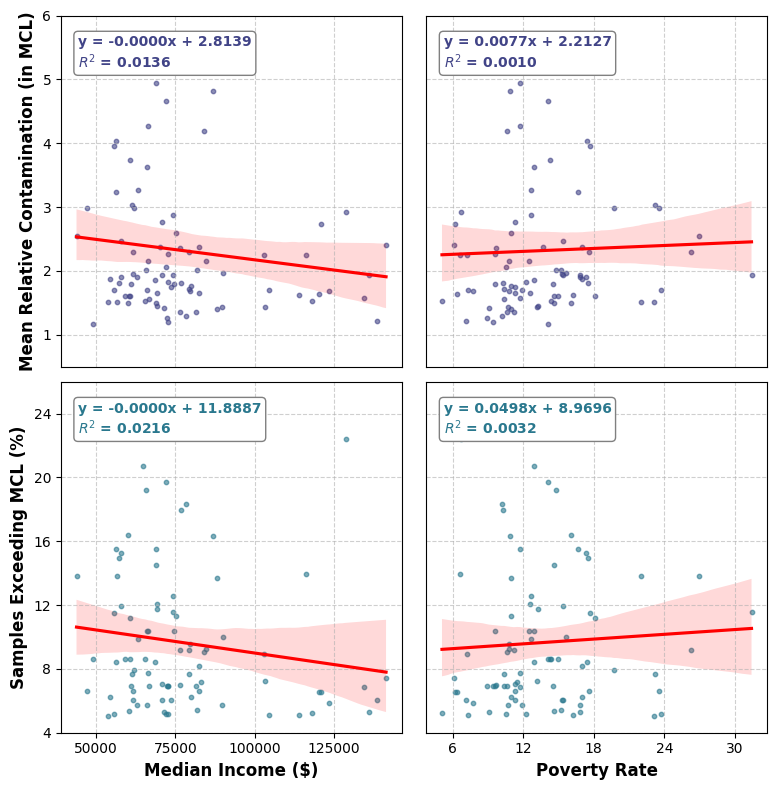

In [25]:
"""Correlation Contamination vs Poverty Data"""

df_counties = df_counties[df_counties["Ratio_MCL"] > 5]

# Drop NaN values to avoid issues
df_filtered = df_counties.dropna(subset=["Median_Income", "Poverty_Rate", 
                                         "Mean_Relative_MCL", 
                                         "Ratio_MCL"])

# Cap Mean Relative Contamination at 8
df_filtered["Mean_Relative_MCL"] = df_filtered["Mean_Relative_MCL"].clip(upper=8)

# Define function to add R² and regression line equation
def add_regression_text(ax, x, y, color):
    x_vals = df_filtered[x].values.reshape(-1, 1)
    y_vals = df_filtered[y].values
    model = LinearRegression().fit(x_vals, y_vals)
    r2 = r2_score(y_vals, model.predict(x_vals))
    
    equation = f"y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}\n$R^2$ = {r2:.4f}"
    
    ax.text(0.05, 0.85, equation, transform=ax.transAxes, 
            fontsize=10, color=color, fontweight="bold",
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# Create a two-column figure layout
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Colors for consistency per row
color_mean = "darkblue"  # Color for Median Income plots
color_equals = "darkgreen"  # Color for Poverty Rate plots

# Plot 1: Median Income vs Mean Relative Contamination
sns.regplot(data=df_filtered, x="Median_Income", y="Mean_Relative_MCL", 
            scatter_kws={'color': colors[0], 'alpha': 0.6, 's': 10}, 
            line_kws={'color': 'red'}, ax=axes[0, 0])

axes[0, 0].set_xlabel("Median Income", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Mean Relative Contamination (in MCL)", fontsize=12, fontweight="bold")
axes[0, 0].set_title("Median Income vs Mean Relative Contamination", fontsize=12, fontweight="bold")
add_regression_text(axes[0, 0], "Median_Income", "Mean_Relative_MCL", colors[0])

# Plot 2: Median Income vs Percentage of Contaminated Samples
sns.regplot(data=df_filtered, x="Median_Income", y="Ratio_MCL", 
            scatter_kws={'color': colors[1], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[1, 0])

axes[1, 0].set_xlabel("Median Income ($)", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Samples Exceeding MCL (%)", fontsize=12, fontweight="bold")
axes[1, 0].set_title("Median Income vs Contaminated Samples", fontsize=12, fontweight="bold")
add_regression_text(axes[1, 0], "Median_Income", "Ratio_MCL", colors[1])

# Plot 3: Poverty Rate vs Mean Relative Contamination
sns.regplot(data=df_filtered, x="Poverty_Rate", y="Mean_Relative_MCL", 
            scatter_kws={'color': colors[0], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[0, 1])

axes[0, 1].set_xlabel("Poverty Rate", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("Mean Relative Contamination", fontsize=12, fontweight="bold")
axes[0, 1].set_title("Poverty Rate vs Mean Relative Contamination", fontsize=12, fontweight="bold")
add_regression_text(axes[0, 1], "Poverty_Rate", "Mean_Relative_MCL", colors[0])

# Plot 4: Poverty Rate vs Percentage of Contaminated Samples
sns.regplot(data=df_filtered, x="Poverty_Rate", y="Ratio_MCL", 
            scatter_kws={'color': colors[1], 'alpha': 0.6, 's': 10},  
            line_kws={'color': 'red'}, ax=axes[1, 1])

axes[1, 1].set_xlabel("Poverty Rate", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Percentage Contaminated Samples", fontsize=12, fontweight="bold")
axes[1, 1].set_title("Poverty Rate vs Contaminated Samples", fontsize=12, fontweight="bold")
add_regression_text(axes[1, 1], "Poverty_Rate", "Ratio_MCL", colors[1])

# Remove all titles
for ax in axes.flat:
    ax.set_title("")

# Remove x-labels for plots 1 (top-left) and 2 (top-right)
axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")

# Remove y-axis labels and ticks for plots 2 (top-right) and 4 (bottom-right)
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")
axes[0, 1].set_yticks([])  # Remove y-axis numbers
axes[1, 1].set_yticks([])  # Remove y-axis numbers
axes[0, 1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axes[0, 0].tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)

axes[1, 1].tick_params(left=False,labelleft=False)



# Set y-axis limit for plots 1 and 2 (first row)
axes[0, 0].set_ylim(0.5, 6)  # Limit y-axis for Plot 1
axes[0, 1].set_ylim(0.5, 6)  # Limit y-axis for Plot 2

axes[1, 0].set_ylim(4, 26)  # Limit y-axis for Plot 1
axes[1, 1].set_ylim(4, 26)  # Limit y-axis for Plot 2

# Adjust layout
plt.tight_layout()

import matplotlib.ticker as mticker

# Loop through all subplots and enable gridlines
for ax in axes.flatten():
    ax.grid(True, linestyle="--", alpha=0.6)  # Dashed gridlines globally

# Ensure consistent grid spacing
for ax in axes.flatten():
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))  # Set same number of y-axis ticks
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))  # Set same number of x-axis ticks

# Manually adjust y-axis for plots 2 and 4
for ax in [axes[0, 1], axes[1, 1]]:
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)  # Ensure gridlines appear






plt.show()